In [1]:
# Get Amazon reviews data
# !wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Home_and_Kitchen_5.json.gz

Download [GloVe](http://nlp.stanford.edu/data/glove.6B.zip) pretrained word embedding vectors


In [3]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm
tqdm.pandas(desc='Progress')
from collections import Counter
from nltk import word_tokenize
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 
# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer
from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json
import pandas as pd
import gzip
# Importing the libraries needed
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

In /home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


# training parameters

In [3]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0  

# load data

In [4]:
%%time
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_full = getDF('reviews_Home_and_Kitchen_5.json.gz')

CPU times: user 16.5 s, sys: 820 ms, total: 17.3 s
Wall time: 16.7 s


In [5]:
df_full.head(2)

reviewerID        asin     reviewerName helpful  \
0   APYOBQE6M18AA  0615391206  Martin Schwartz  [0, 0]   
1  A1JVQTAGHYOL7F  0615391206    Michelle Dinh  [0, 0]   

                                          reviewText  overall     summary  \
0  My daughter wanted this book and the price on ...      5.0  Best Price   
1  I bought this zoku quick pop for my daughterr ...      5.0        zoku   

   unixReviewTime   reviewTime  
0      1382140800  10 19, 2013  
1      1403049600  06 18, 2014

In [ ]:
df

In [6]:
df = df_full[['reviewText','overall']]
print(df.shape)
df.head(2)

(551682, 2)


reviewText  overall
0  My daughter wanted this book and the price on ...      5.0
1  I bought this zoku quick pop for my daughterr ...      5.0

## EDA

In [7]:
%%time
pd.options.display.max_colwidth = 1000
# read 10 random reviews with their rating
import random
rand_nums = random.sample(range(1, 551682), 2)
for num in rand_nums:
    print(df['reviewText'].loc[[num]])
    print(df['overall'].loc[[num]])
    print("")

60941    This is a good pitcher, good price, arrived in one piece..bravo! I do not find it heavy or awkward. Fits the bill for water on the table at a dinner event. It's interesting enough to look at.
Name: reviewText, dtype: object
60941    5.0
Name: overall, dtype: float64

310480    Kirby bags are impossible to find in my area (not the demographic that would pay $1200 for a vacuum, lol).  These are genuine Kirby bags and fit perfectly...not to mention the great price!
Name: reviewText, dtype: object
310480    5.0
Name: overall, dtype: float64

CPU times: user 21.5 ms, sys: 85 µs, total: 21.6 ms
Wall time: 20.4 ms


5.0    63.387241
4.0    19.124786
3.0     8.167568
1.0     4.913338
2.0     4.407068
Name: overall, dtype: float64


[Text(0, 0.5, '%'), Text(0.5, 0, 'rating')]

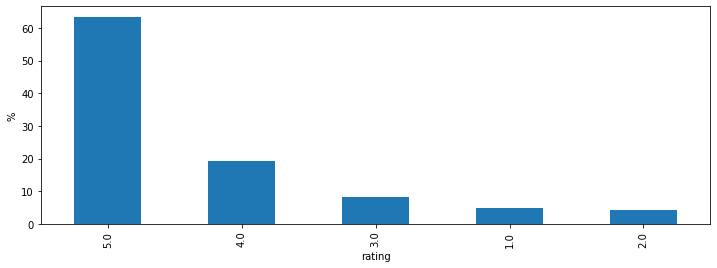

In [8]:
# what is the distribution of ratings?
pd.options.display.max_colwidth = 50
df = df_full[['reviewText','overall']]
# df.groupby(['overall']).count().plot.bar(figsize=(12,4))
as_perct = df['overall'].value_counts()/df['overall'].count()*100
print(as_perct)
as_perct.plot.bar(figsize=(12,4)).set(xlabel='rating',ylabel='%')

## Make classes equal 

In [9]:
# sample only 20k from each category
df.groupby(['overall']).count()

reviewText
overall            
1.0           27106
2.0           24313
3.0           45059
4.0          105508
5.0          349696

In [10]:
new_df_5 = df[df['overall']==5][:20000]
new_df_4 = df[df['overall']==4][:20000]
new_df_3 = df[df['overall']==3][:20000]
new_df_2 = df[df['overall']==2][:20000]
new_df_1 = df[df['overall']==1][:20000]

In [11]:
pdList = [new_df_1,new_df_2,new_df_3,new_df_4,new_df_5]
df = pd.concat(pdList)
df.groupby(['overall']).count()

reviewText
overall            
1.0           20000
2.0           20000
3.0           20000
4.0           20000
5.0           20000

In [12]:
df.reset_index(drop=True,inplace=True)
df.head(2)

reviewText  overall
0  This is so remedial.  Buy a Wilton magazine fo...      1.0
1  I did sloppy shopping. This machine is exactly...      1.0

In [15]:
data = df

In [16]:
# change names
data.columns

Index(['reviewText', 'overall'], dtype='object')

In [17]:
data.columns = ["review","condition"]

In [18]:
# change data types to string so type(0) is a string and not an int
data['condition'] = data['condition'].apply(str)

In [19]:
# print(data["condition"].dtypes)
# type(data['condition'][0])

## finding the maxlen

In [20]:
data['len'] = data['review'].apply(lambda s : len(s))

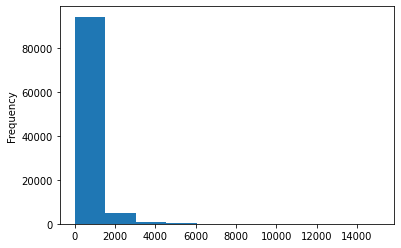

In [21]:
data['len'].plot.hist(bins=10)

In [22]:
data.len.quantile(0.9)

1185.0

In [23]:
del data['len']

In [24]:
data.head(2)

review condition
0  This is so remedial.  Buy a Wilton magazine fo...       1.0
1  I did sloppy shopping. This machine is exactly...       1.0

In [25]:
count_df = data[['condition','review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review',ascending=False)
count_df.head()

condition  review
0       1.0   20000
1       2.0   20000
2       3.0   20000
3       4.0   20000
4       5.0   20000

In [26]:
target_conditions = count_df[count_df['review']>3000]['condition'].values

## text parsing and pre-processing

In [27]:
def condition_parser(x):
    if x in target_conditions:
        return x
    else:
        return "OTHER"
    
data['condition'] = data['condition'].apply(lambda x: condition_parser(x))  

In [28]:
data = data[data['condition']!='OTHER']

In [31]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [32]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("this's a text with contraction")

'this is a text with contraction'

In [33]:
# lower the text
data["review"] = data["review"].apply(lambda x: x.lower())

# Clean the text
data["review"] = data["review"].apply(lambda x: clean_text(x))

# Clean numbers
data["review"] = data["review"].apply(lambda x: clean_numbers(x))

# Clean Contractions
data["review"] = data["review"].apply(lambda x: replace_contractions(x))

In [34]:
# data['condition'].unique()

## train test split and tokenize

In [35]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['review'], data['condition'],
                                                    stratify=data['condition'], 
                                                    test_size=0.25)

In [36]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (75000,)
Test shape :  (25000,)


In [37]:
%%time
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

CPU times: user 10.7 s, sys: 132 ms, total: 10.9 s
Wall time: 10.9 s


In [38]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [39]:
le.classes_

array(['1.0', '2.0', '3.0', '4.0', '5.0'], dtype=object)

## load embeddings


In [40]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index):
    EMBEDDING_FILE = 'glove.840B.300d.txt'
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')[:300]
    
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [41]:
%%time
# TAKES A MINUTE TO RUN
# When ran this on full amazon review dataset got 120k tokens
# now running on equal classes (20k from each rating level) got 56979 tokens
# missing entries in the embedding are set using np.random.normal so we have to seed here too

# if debug:
#     embedding_matrix = np.random.randn(120000,300)
# else:
#     embedding_matrix = load_glove(tokenizer.word_index)

embedding_matrix = load_glove(tokenizer.word_index)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 2min 24s, sys: 4.65 s, total: 2min 29s
Wall time: 2min 28s


In [42]:
np.shape(embedding_matrix)

(57056, 300)

# train and test TextCNN model
Takes about 16minutes to train on full Home and Kitchen segment which contains ~550k reviews. When subset to 20k from each rating trains in about 35seconds per epoch

In [43]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

In [44]:
n_epochs = 10
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/10 	 loss=694.8388 	 val_loss=606.2733  	 val_acc=0.4901  	 time=35.99s
Epoch 2/10 	 loss=580.6655 	 val_loss=563.0586  	 val_acc=0.5278  	 time=37.46s
Epoch 3/10 	 loss=542.7314 	 val_loss=544.5972  	 val_acc=0.5389  	 time=39.60s
Epoch 4/10 	 loss=517.7863 	 val_loss=536.3871  	 val_acc=0.5452  	 time=41.01s
Epoch 5/10 	 loss=498.0732 	 val_loss=531.4562  	 val_acc=0.5501  	 time=42.63s
Epoch 6/10 	 loss=480.2968 	 val_loss=533.7413  	 val_acc=0.5459  	 time=44.63s
Epoch 7/10 	 loss=464.4000 	 val_loss=533.8243  	 val_acc=0.5493  	 time=46.19s
Epoch 8/10 	 loss=448.9753 	 val_loss=532.7953  	 val_acc=0.5474  	 time=47.41s
Epoch 9/10 	 loss=434.5751 	 val_loss=530.8668  	 val_acc=0.5522  	 time=47.59s
Epoch 10/10 	 loss=422.2265 	 val_loss=541.3701  	 val_acc=0.5433  	 time=47.89s


In [45]:
torch.save(model,'amazon_balanced_textcnn_model')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN_Text. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [46]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

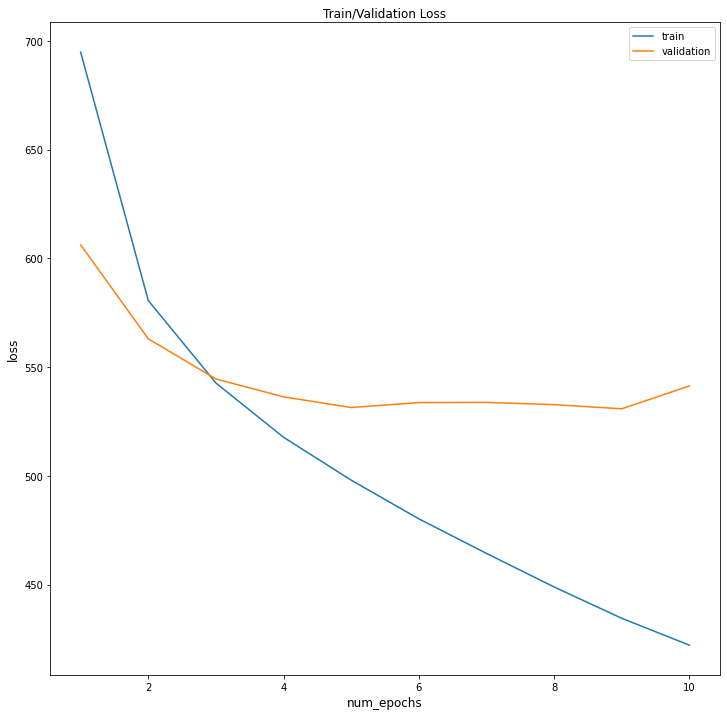

In [47]:
plot_graph(n_epochs)

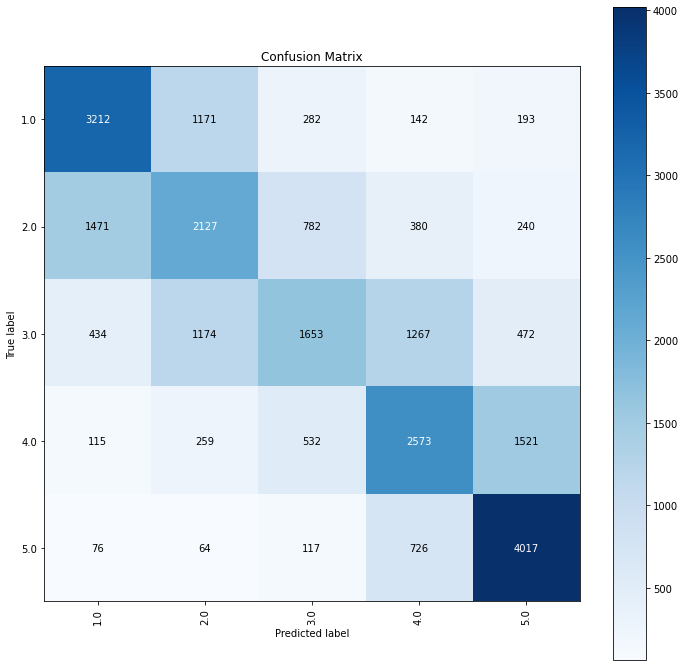

In [48]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [49]:
from sklearn.metrics import classification_report
print("<<Bidirectional LSTM classification>> \n")
print(classification_report(y_true,y_pred))

<<Bidirectional LSTM classification>> 

              precision    recall  f1-score   support

         1.0       0.61      0.64      0.62      5000
         2.0       0.44      0.43      0.43      5000
         3.0       0.49      0.33      0.40      5000
         4.0       0.51      0.51      0.51      5000
         5.0       0.62      0.80      0.70      5000

    accuracy                           0.54     25000
   macro avg       0.53      0.54      0.53     25000
weighted avg       0.53      0.54      0.53     25000



# train and test BiLSTM model

In [50]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [1]:
n_epochs = 30
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

NameError: name 'BiLSTM' is not defined

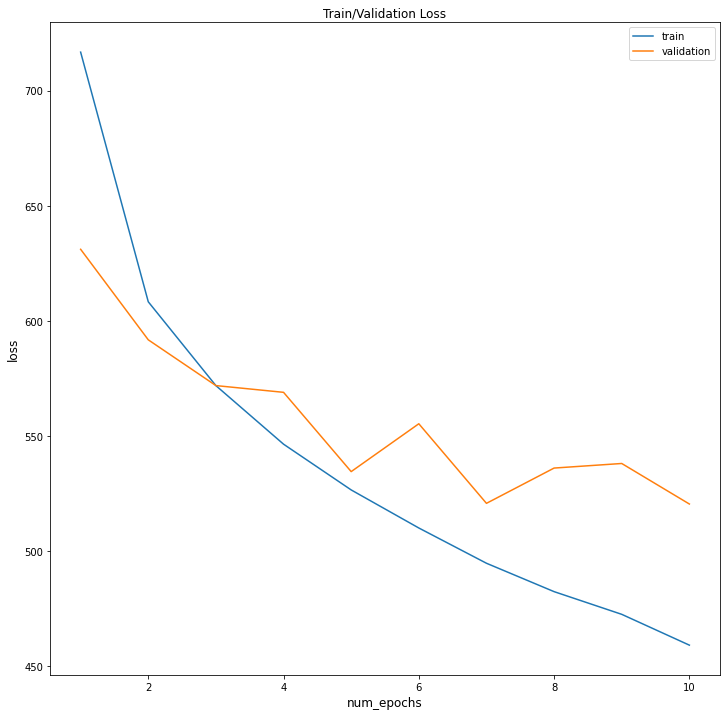

In [52]:
plot_graph(n_epochs)

In [53]:
torch.save(model,'amazon_balanced_bilstm_model')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


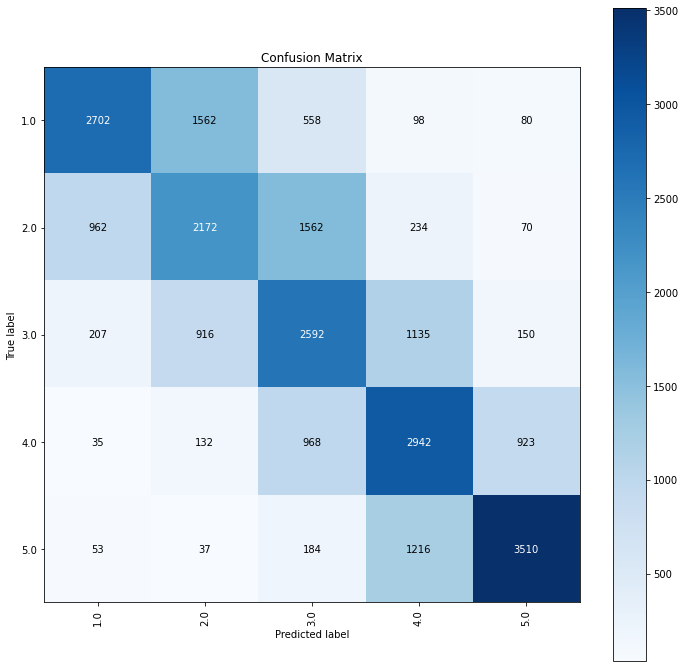

In [54]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [55]:
from sklearn.metrics import classification_report
print("<<Bidirectional LSTM classification>> \n")
print(classification_report(y_true,y_pred))

<<Bidirectional LSTM classification>> 

              precision    recall  f1-score   support

         1.0       0.68      0.54      0.60      5000
         2.0       0.45      0.43      0.44      5000
         3.0       0.44      0.52      0.48      5000
         4.0       0.52      0.59      0.55      5000
         5.0       0.74      0.70      0.72      5000

    accuracy                           0.56     25000
   macro avg       0.57      0.56      0.56     25000
weighted avg       0.57      0.56      0.56     25000



In [56]:
def predict_single(x):    
    # lower the text
    x = x.lower()
    # Clean the text
    x =  clean_text(x)
    # Clean numbers
    x =  clean_numbers(x)
    # Clean Contractions
    x = replace_contractions(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]

In [57]:
x = data['review'].values[20]
print(x)

this blender is unreliable and does not work well for smoothies (our main use for a blender). when the cutter assembly broke (after ~## uses) i contacted cuisinart about a warranty replacement. since the blender was purchased as a gift (from our wedding registry), we did not have "proof of purchase" and cuisinart did not honor the 3-year warranty.we purchased a replacement part from cuisinartwebstore.com (~$## with shipping) and got through another ~## uses before that cutter assembly broke as well. this time with a proof of purchase in hand i called cuisinart customer "service" again only to learn they do not warranty items bought at the webstore (i.e. the replacement part had no warranty).if we could rate a company / brand here as well i would give one star to cuisinart (i.e. conair) for their shoddy product quality and poor customer service.


In [58]:
predict_single(x)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'1.0'

# train and test Transformer model

In [4]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
%%time
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_full = getDF('reviews_Home_and_Kitchen_5.json.gz')

CPU times: user 15.9 s, sys: 772 ms, total: 16.7 s
Wall time: 16.7 s


In [38]:
# df_full.head(2)

In [6]:
df = df_full[['reviewText','overall']] # get only these cols
print(df.shape)
df.head(2)

(551682, 2)


reviewText  overall
0  My daughter wanted this book and the price on ...      5.0
1  I bought this zoku quick pop for my daughterr ...      5.0

In [7]:
df.shape

(551682, 2)

In [8]:
df.columns = ["TITLE","CATEGORY"]

In [9]:
# change data types to string so type(0) is a string and not an int
df['CATEGORY'] = df['CATEGORY'].apply(str)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [35]:
# df.head(2)

In [10]:
type(df["CATEGORY"][0])

str

In [11]:
# # Converting the codes to appropriate categories using a dictionary
my_dict = {
    '1.0':'one',
    '2.0':'two',
    '3.0':'three',
    '4.0':'four',
    '5.0':'five',
}

def update_cat(x):
    return my_dict[x]

df['CATEGORY'] = df['CATEGORY'].apply(lambda x: update_cat(x))
encode_dict = {}

def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

df['ENCODE_CAT'] = df['CATEGORY'].apply(lambda x: encode_cat(x))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
df.head(2)

TITLE CATEGORY  ENCODE_CAT
0  My daughter wanted this book and the price on ...     five           0
1  I bought this zoku quick pop for my daughterr ...     five           0

In [13]:
df.shape

(551682, 3)

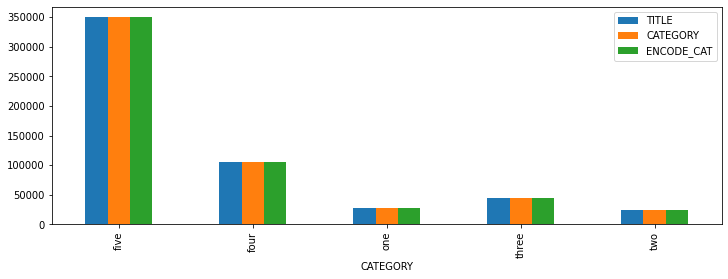

In [14]:
df.groupby([df["CATEGORY"]]).count().plot.bar(figsize=(12,4))

In [15]:
new_df_5 = df[df["CATEGORY"]=="five"][:20000]
new_df_4 = df[df["CATEGORY"]=="four"][:20000]
new_df_3 = df[df["CATEGORY"]=='three'][:20000]
new_df_2 = df[df["CATEGORY"]=="two"][:20000]
new_df_1 = df[df["CATEGORY"]=="one"][:20000]

In [16]:
pdList = [new_df_1,new_df_2,new_df_3,new_df_4,new_df_5]
df = pd.concat(pdList)
df.groupby(["CATEGORY"]).count()

TITLE  ENCODE_CAT
CATEGORY                   
five      20000       20000
four      20000       20000
one       20000       20000
three     20000       20000
two       20000       20000

In [17]:
df.reset_index(drop=True,inplace=True)
print(df.shape)
df.head(2)

(100000, 3)


TITLE CATEGORY  ENCODE_CAT
0  This is so remedial.  Buy a Wilton magazine fo...      one           4
1  I did sloppy shopping. This machine is exactly...      one           4

In [ ]:
# do all preprocessing from before



In [18]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 5
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [19]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.TITLE[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.ENCODE_CAT[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [20]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset = df.sample(frac=train_size, random_state=200).reset_index(drop=True)
test_dataset = df.drop(train_dataset.index).reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

# using pretrained BERT tokenizer
training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (100000, 3)
TRAIN Dataset: (80000, 3)
TEST Dataset: (20000, 3)


In [21]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [22]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 1)
    
    def forward(self, ids, mask):
        output_1= self.l1(ids, mask)
        output_2 = self.l2(output_1[0])
        output = self.l3(output_2)
        return output

In [23]:
model = DistillBERTClass()
model.to(device)

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

In [24]:
device

'cuda'

In [25]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [26]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask).squeeze()

        optimizer.zero_grad()
        loss = loss_function(outputs, targets)
        # 5000 steps takes 16min
#         if _%5000==0:
        #500 steps takes 1.6min (Also contracted data from 440k to 80k)
        # instead of 800k
        if _%500==0:
#         if _%50==0:

            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [27]:
%%time
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  6.263404369354248
Epoch: 0, Loss:  1.9717247486114502
Epoch: 0, Loss:  1.5265705585479736
Epoch: 0, Loss:  1.2817344665527344
Epoch: 0, Loss:  1.6600143909454346
Epoch: 0, Loss:  1.5802050828933716
Epoch: 0, Loss:  1.544062852859497
Epoch: 0, Loss:  1.484386682510376
Epoch: 0, Loss:  1.7368769645690918
Epoch: 0, Loss:  1.4876818656921387
Epoch: 0, Loss:  1.6706633567810059
Epoch: 0, Loss:  1.4969489574432373
Epoch: 0, Loss:  1.6644983291625977
Epoch: 0, Loss:  1.7558660507202148
Epoch: 0, Loss:  1.8346878290176392
Epoch: 0, Loss:  1.2595510482788086
Epoch: 0, Loss:  1.9694583415985107
Epoch: 0, Loss:  1.2346515655517578
Epoch: 0, Loss:  1.1099824905395508
Epoch: 0, Loss:  1.264153003692627
Epoch: 0, Loss:  1.558678150177002
Epoch: 0, Loss:  1.3726749420166016
Epoch: 0, Loss:  0.9924095869064331
Epoch: 0, Loss:  1.4431071281433105
Epoch: 0, Loss:  0.8822276592254639
Epoch: 0, Loss:  2.337742567062378
Epoch: 0, Loss:  0.9893311262130737
Epoch: 0, Loss:  0.980708479881286

In [28]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            total+=targets.size(0)
            n_correct+=(big_idx==targets).sum().item()
    return (n_correct*100.0)/total

In [29]:
# takes couple minutes to run on total data of 40k
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Accuracy on test data = 88.04%
